In [1]:
import os
import torch
import sys
import numpy
import matplotlib.pyplot as plt

from torchvision import transforms
import torch.utils.data as Data
from torch.autograd import Variable

sys.path.append('../')

from src.mnist.autoencoder import ConvAutoEncoder2
from src.mnist.data import load_mnist, load_mnist_fashion

In [2]:
# Set some hyperparameters
MODEL_NAME = "../mnist_ae_model.h5"
NB_EXAMPLES = 10
NOISE_PRC = 0.5
DOWNLOAD_MNIST = False
CLASS_SELECTED = [6]
CLASS_CORRUPTED = [0,1,2,3,4,5,7,8,9]
PATH_DATA = os.path.join(os.path.expanduser("~"), 'Downloads/mnist')

#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = "cpu"

Load the model and few examples

In [3]:
# Load pretrained model
model = ConvAutoEncoder2()
model.load_state_dict(torch.load(MODEL_NAME))
model.to(device)

#Load few examples
_, data = load_mnist(PATH_DATA, download=DOWNLOAD_MNIST)

# Build "train" and "test" datasets
id_maj = numpy.random.choice(
    numpy.where(numpy.isin(data.test_labels, CLASS_SELECTED))[0],
    int((1 - NOISE_PRC) * NB_EXAMPLES),
    replace=False
)
id_min = numpy.random.choice(
    numpy.where(numpy.isin(data.test_labels, CLASS_CORRUPTED))[0],
    int(NOISE_PRC * NB_EXAMPLES),
    replace=False
)
id = numpy.concatenate((id_maj, id_min))

#data.data.to(torch.double)
#data.data = data.data / 255.

data.data = data.data[id]
data.targets = data.targets[id]

train_loader = Data.DataLoader(dataset=data,
                               batch_size=64)


for i, (x, y) in enumerate(train_loader):
    x = Variable(x)
    x = x.to(device)
    encoded, decoded = model(x)
    
    if i == 0:
        generated_x = decoded

/home/stepcaro/.conda/envs/memoire/lib/python3.8/site-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


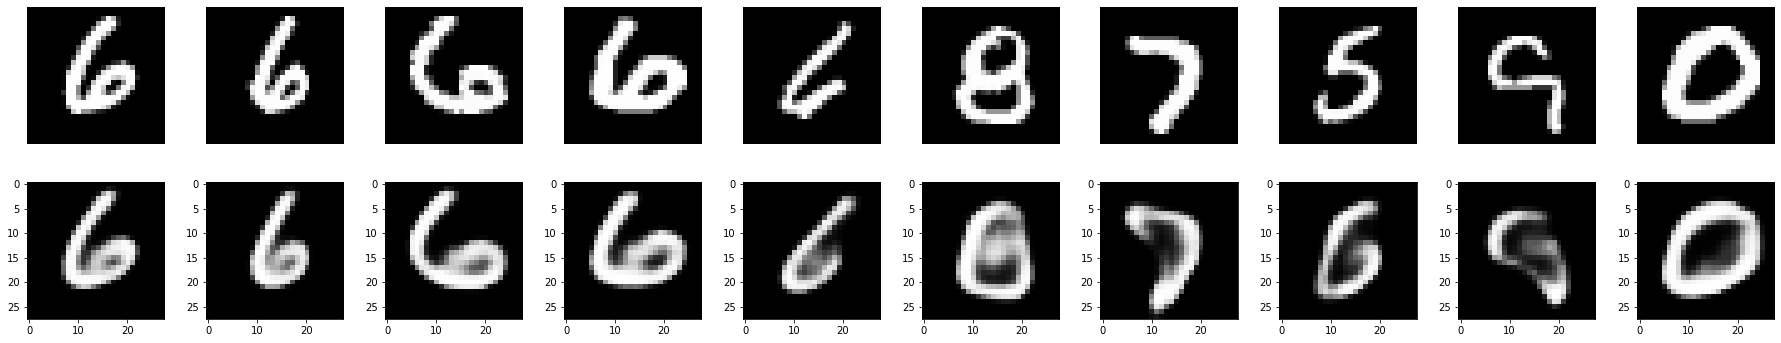

In [4]:
plt.rcParams['figure.figsize'] = [25, 5]

fig, axs = plt.subplots(2, 10)
fig.tight_layout()
axs = axs.ravel()

for i in range(20):
    if i < 10:
        image = data.data[i]
        axs[i].imshow(image, cmap='gray')
        axs[i].axis('off')
    else:
        image = generated_x[i-10].squeeze(0).reshape(28,28).detach().numpy()
        axs[i].imshow(image, cmap='gray')
        

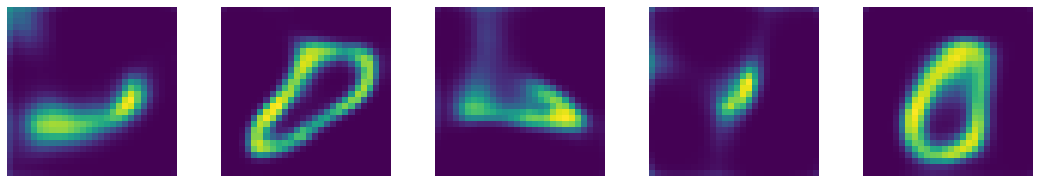

In [44]:
plt.rcParams['figure.figsize'] = [15, 5]

MU = numpy.repeat(0, LATENT_DIM)
SIGMA = numpy.diag(numpy.repeat(1, LATENT_DIM))
dt_sim = numpy.random.multivariate_normal(mean=MU, cov=SIGMA, size=32)

fig, axs = plt.subplots(1, 5)
fig.tight_layout()
axs = axs.ravel()

x = torch.from_numpy(dt_sim).float().to(device)
generated = model.decode(x)

for i in range(5):
    image = generated[i].squeeze(0).reshape(28,28).detach().numpy()
    axs[i].imshow(image)
    axs[i].axis('off')

In [23]:
cutoff = int(NB_EXAMPLES/2)

print(numpy.mean(numpy.mean(z_mu[0:cutoff], 0)))
print(numpy.mean(numpy.mean(z_mu[cutoff:NB_EXAMPLES], 0)))
print(numpy.mean(numpy.mean(numpy.exp(z_logvar[0:cutoff]), 0)))
print(numpy.mean(numpy.mean(numpy.exp(z_logvar[cutoff:NB_EXAMPLES]), 0)))

#print(numpy.mean(z_mu[0:cutoff], 0))
#print(numpy.mean(z_mu[cutoff:NB_EXAMPLES], 0))

#print(numpy.mean(numpy.exp(z_logvar[0:cutoff]), 0))
#print(numpy.mean(numpy.exp(z_logvar[cutoff:NB_EXAMPLES]), 0))

0.00077666104
-0.0018877205
1.0014232
0.9999739


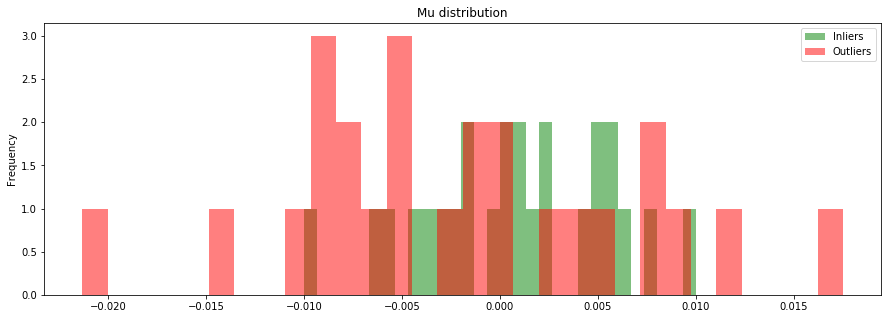

In [24]:
mu_cars = numpy.mean(z_mu[0:cutoff], axis=0)
mu_dogs = numpy.mean(z_mu[cutoff:NB_EXAMPLES], axis=0)
kwargs = dict(alpha=0.5, bins=30)
plt.hist(mu_cars, **kwargs, color='g', label='Inliers')
plt.hist(mu_dogs, **kwargs, color='r', label='Outliers')
plt.gca().set(title='Mu distribution', ylabel='Frequency')
plt.legend()

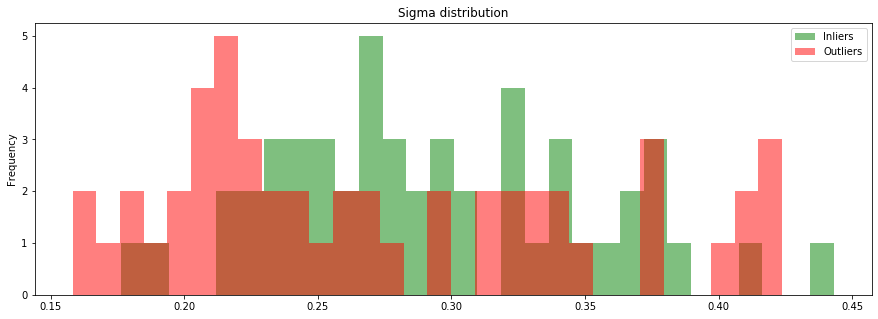

In [171]:
logvar_cars = numpy.mean(numpy.exp(z_logvar[0:cutoff]), axis=1)
logvar_dogs = numpy.mean(numpy.exp(z_logvar[cutoff:NB_EXAMPLES]), axis=1)
kwargs = dict(alpha=0.5, bins=30)
plt.hist(logvar_cars, **kwargs, color='g', label='Inliers')
plt.hist(logvar_dogs, **kwargs, color='r', label='Outliers')
plt.gca().set(title='Sigma distribution', ylabel='Frequency')
plt.legend()